In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent / "Results"); os.chdir(set_path)

In [5]:
sub_dir = "mogdog__32dim_ReverseIAF_epochs100000_flowsteps20_dist4__2021_07_18-12_07_07_AM"

In [6]:
text= open(sub_dir + '/results.txt', "r").readlines()
text

['*********     Parameters      *******************\n',
 '\n',
 'dim 32\n',
 'save_path Results/mogdog__32dim_ReverseIAF_epochs100000_flowsteps20_dist4__2021_07_18-12_07_07_AM\n',
 'epochs 100000\n',
 'n_flow_steps 20\n',
 'n_distributions 4\n',
 'flow_type ReverseIAF\n',
 'batch_size 1000\n',
 'seed 0\n',
 'n_samples_expectation 100000\n',
 'save True\n',
 'n_plots 20\n',
 'train_AIS_params False\n',
 'step_size 1.0\n',
 "learnt_dist_kwargs {'lr': 0.0005, 'optimizer': 'AdamW'}\n",
 '\n',
 '\n',
 ' *******************************    Results ********************* \n',
 '\n',
 'ESS of AIS before training is 2.5498554412717685e-05 calculated using 100000 samples \n',
 'ESS for samples from AIS  0.15652403997014866 calculated using 100000 samples \n',
 'ESS for samples from AIS of repeat calc 0.14922161226710445 calculated using 100000 samples \n',
 'ESS of flow model after training is 0.07023827645080252 calculated using 100000 samples']

In [7]:
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [34]:
from AIS_train.train_AIS import AIS_trainer
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.Models.FlowModel import FlowModel
from Utils.numerical_utils import quadratic_function as expectation_function
import torch

In [14]:
# 32 dim
dim = 32
flow_type="ReverseIAF"
n_flow_steps = 20
step_size = 1.0
n_distributions = 4
learnt_dist_kwargs = {'lr': 0.0005, 'optimizer': 'AdamW'}
HMC_transition_args = {"step_tuning_method": "p_accept"}
batch_size = int(1e4)
n_samples_expectation = int(1e5)

In [23]:
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type=flow_type,
                               n_flow_steps=n_flow_steps)
tester = AIS_trainer(target, learnt_sampler, n_distributions=n_distributions, learnt_dist_kwargs=learnt_dist_kwargs
                    , tranistion_operator_kwargs=HMC_transition_args, transition_operator="HMC")
tester.learnt_sampling_dist.load_model(cwd_path.parent / "Results/" / sub_dir)

setting device as cuda
loaded model


In [ ]:
# Calculate ESS over flow model
expectation_flo, info_dict_flo = tester.AIS_train.calculate_expectation_over_flow(n_samples_expectation,
                                                                  expectation_function=expectation_function,
                                                                  batch_size=batch_size,
                                                                  drop_nan_and_infs=True)
info_dict_flo['effective_sample_size'].item()/ n_samples_expectation

In [28]:
# Calculate ESS over AIS trainer
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                    batch_size=batch_size,
                                                                    drop_nan_and_infs=True)
info_dict['effective_sample_size'].item() / n_samples_expectation

0.07533761663056229

In [41]:
# We have to do the below for old models where we didn't save params
tester.AIS_train.transition_operator_class.epsilons = torch.ones_like(tester.AIS_train.transition_operator_class.epsilons)*0.07
tester.AIS_train.transition_operator_class.common_epsilon = \
    torch.ones_like(tester.AIS_train.transition_operator_class.common_epsilon)*0.075

In [42]:
# Calculate ESS over AIS trainer
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                    batch_size=batch_size,
                                                                    drop_nan_and_infs=True)
info_dict['effective_sample_size'].item() / n_samples_expectation

0.148251194757286

# Let's test for different numbers of intermediate distributions

In [87]:
def run(n_intermediate_distributions, good_transition=True):
    # 32 dim
    dim = 32
    flow_type="ReverseIAF"
    n_flow_steps = 20
    step_size = 1.0
    n_distributions = 2 + n_intermediate_distributions
    learnt_dist_kwargs = {'lr': 0.0005, 'optimizer': 'AdamW'}
    HMC_transition_args = {"step_tuning_method": "p_accept"}
    batch_size = int(5e4)
    n_samples_expectation = int(1e5)
    ####
    target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)
    learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type=flow_type,
                                   n_flow_steps=n_flow_steps)
    tester = AIS_trainer(target, learnt_sampler, n_distributions=n_distributions, learnt_dist_kwargs=learnt_dist_kwargs
                        , tranistion_operator_kwargs=HMC_transition_args, transition_operator="HMC")
    # We have to do the below for old models where we didn't save params
    if good_transition:
        tester.AIS_train.transition_operator_class.epsilons = \
            torch.ones_like(tester.AIS_train.transition_operator_class.epsilons)*0.07
        tester.AIS_train.transition_operator_class.common_epsilon = \
            torch.ones_like(tester.AIS_train.transition_operator_class.common_epsilon)*0.075
    #  load model 
    tester.learnt_sampling_dist.load_model(cwd_path.parent / "Results/" / sub_dir)
    # ******************
    # Calculate ESS over AIS trainer
    expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                        expectation_function=expectation_function,
                                                                        batch_size=batch_size,
                                                                        drop_nan_and_infs=True)
    return info_dict['effective_sample_size'].item() / n_samples_expectation, info_dict["samples"]

In [88]:
print(run(n_intermediate_distributions=1)[0])

setting device as cuda
loaded model
0.1274322978835707


In [89]:
import numpy as np
import matplotlib.pyplot as plt

In [90]:
n_intermediate_dist_options = [1,2,4,8, 16, 32, 64]

In [91]:
ESS_history = []
Sample_history = []
for n_intermediate_dist in n_intermediate_dist_options:
    ESS, samples = run(n_intermediate_dist)
    ESS_history.append(ESS)
    Sample_history.append(samples)
    print(f"ESS for {n_intermediate_dist} dist is {ESS}")

setting device as cuda
loaded model
ESS for 1 dist is 0.1274322978835707
setting device as cuda
loaded model
ESS for 2 dist is 0.161999382901336
setting device as cuda
loaded model
ESS for 4 dist is 0.1969009961689111
setting device as cuda
loaded model
ESS for 8 dist is 0.2688220983810257
setting device as cuda
loaded model
ESS for 16 dist is 0.3444620516932083
setting device as cuda
loaded model
ESS for 32 dist is 0.4536420970306618
setting device as cuda
loaded model
ESS for 64 dist is 0.5591661903980643


Text(0.5, 0, 'Number of intermediate AIS distributions')

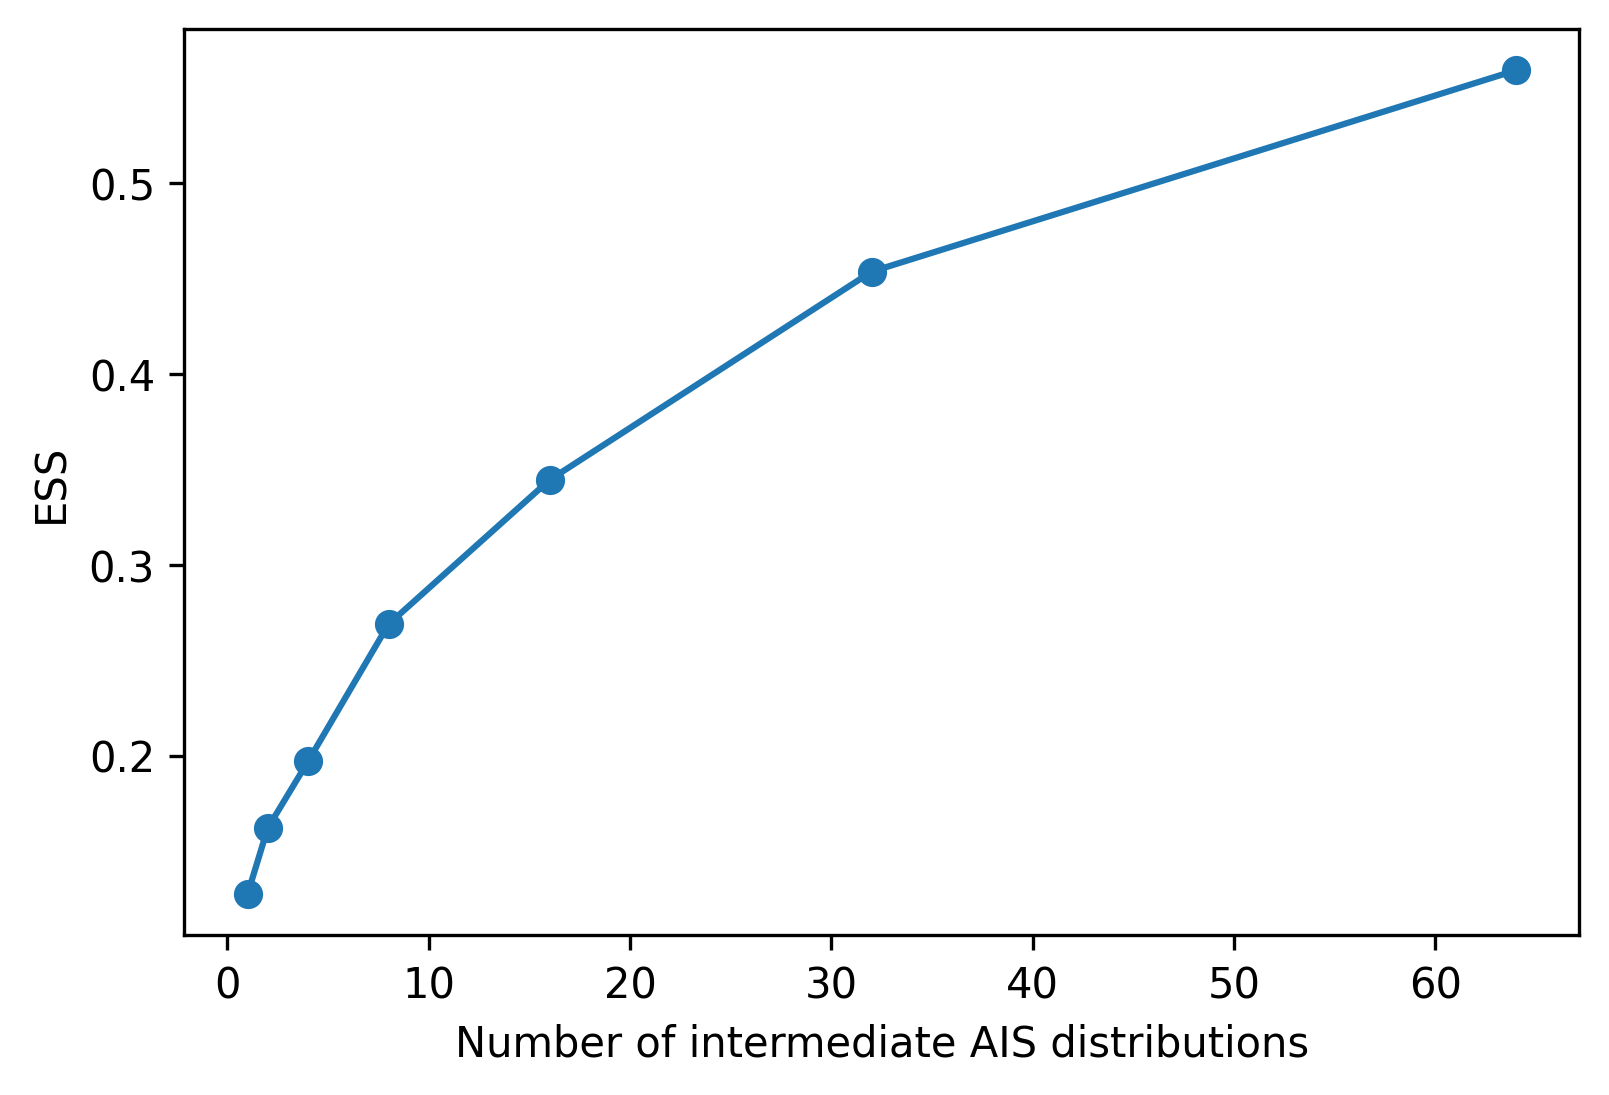

In [92]:
plt.plot(n_intermediate_dist_options, ESS_history, "o-")
plt.ylabel("ESS")
plt.xlabel("Number of intermediate AIS distributions")

In [93]:
ESS_history_bad = []
Sample_history_bad = []
for n_intermediate_dist in n_intermediate_dist_options:
    ESS, samples = run(n_intermediate_dist, good_transition=False)
    ESS_history_bad.append(ESS)
    Sample_history_bad.append(samples)
    print(f"ESS for {n_intermediate_dist} dist is {ESS}")

setting device as cuda
loaded model
ESS for 1 dist is 0.05473903724384884
setting device as cuda
loaded model
ESS for 2 dist is 0.05907985462493196
setting device as cuda
loaded model
ESS for 4 dist is 0.05473943736303815
setting device as cuda
loaded model
ESS for 8 dist is 0.05669614859872452
setting device as cuda
loaded model
ESS for 16 dist is 0.056708574432721086
setting device as cuda
loaded model
ESS for 32 dist is 0.05790494299730109
setting device as cuda
loaded model
ESS for 64 dist is 0.05545101753013754


In [94]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

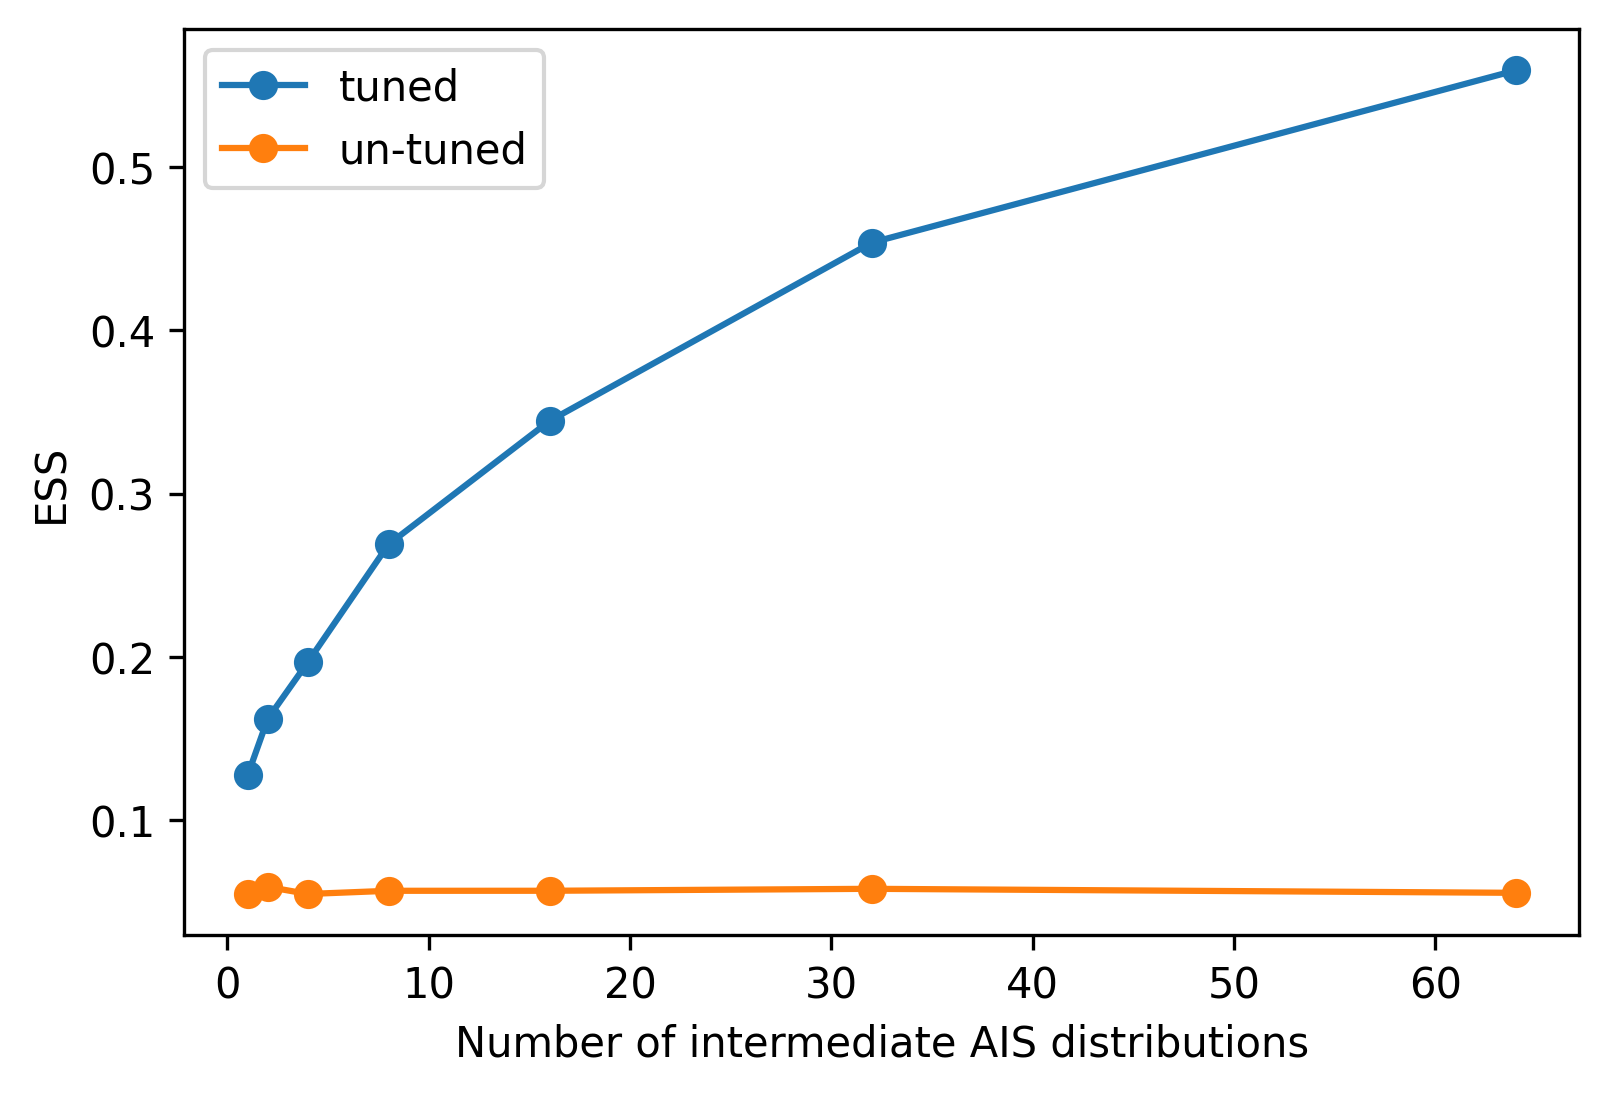

In [95]:
plt.plot(n_intermediate_dist_options, ESS_history, "o-", label="tuned")
plt.plot(n_intermediate_dist_options, ESS_history_bad, "o-", label="un-tuned")
plt.ylabel("ESS")
plt.xlabel("Number of intermediate AIS distributions")
plt.legend()
#plt.xlim([0, 70])